In [2]:
#inttatlize packages
from viresclient import set_token
from viresclient import SwarmRequest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import mplcyberpunk
from itertools import chain
import pickle
from scipy.fft import fft, fftfreq
import asilib
import asilib.asi
import cdflib
import xarray
import resampy
from scipy import signal


c:\Users\1101w\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
#Set key for getting data
set_token("https://vires.services/ows", set_default=True,
          token="kmxv5mTTyYwzw4kQ9lsCkGfQHtjjJRVZ")  # key
plt.style.use("cyberpunk")  # Dark mode!


Token saved for https://vires.services/ows


In [4]:
#request high resolution magnetic data for swarm A during the auroral interval in Miles Et Al
Magnetic_products = ["SW_OPER_MAGA_HR_1B",
                     "SW_OPER_MAGB_HR_1B", "SW_OPER_MAGC_HR_1B"]
data_frame_B=[]
time_range=(datetime(2021,3,18,8,13),datetime(2021,3,18,8, 25))
time_xarray=[]
for i in range(3):
    request = SwarmRequest()
    request.set_collection(
        Magnetic_products[i])
    request.set_products(
        measurements=["B_NEC"],
        models=["CHAOS"],
        residuals=True,  # grabs residual from chaos
    )
    data = request.get_between(
        start_time=time_range[0],
        end_time=time_range[1],
        asynchronous=False,
    )
    # changes data into a dataframe format, which is easy to use
    df_b=data.as_dataframe()
    length_of_timeseries = len(df_b)
    B_data_used = np.zeros((length_of_timeseries, 3))

    B_data_numpy = df_b['B_NEC_res_CHAOS'].to_numpy()
    ##B_data_numpy = df_b['B_NEC'].to_numpy()
    for i in range(length_of_timeseries):
        for j in range(3):

            B_data_used[i][j] = B_data_numpy[i][j]
    
    time_xarray.append(df_b['B_NEC_res_CHAOS'].index)
    ##time_xarray.append(df_b['B_NEC'].index)
    data_frame_B.append(B_data_used)
time_xarray[1]=np.flip(time_xarray[1])


Downloading: 100%|██████████|  [ Elapsed: 00:11, Remaining: 00:00 ] (2.057MB)
Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (2.057MB)
Downloading: 100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ] (2.057MB)


In [5]:
def moving_average(a):
    n = int(len(a)/((time_range[1]-time_range[0]).total_seconds()/60))  # gives 60 second averaging
    print(n/50, 'seconds average')
    y_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((n,))/n, mode='valid')
    print(len(y_smooth))
    return y_smooth


In [6]:
for i in range(3):
    for k in range(3):
        data_frame_B[i][:, k] = moving_average(
            data_frame_B[i][:, k])-data_frame_B[i][:, k]


60.0 seconds average
36002
60.0 seconds average
36002
60.0 seconds average
36002
60.0 seconds average
36003
60.0 seconds average
36003
60.0 seconds average
36003
60.0 seconds average
36002
60.0 seconds average
36002
60.0 seconds average
36002


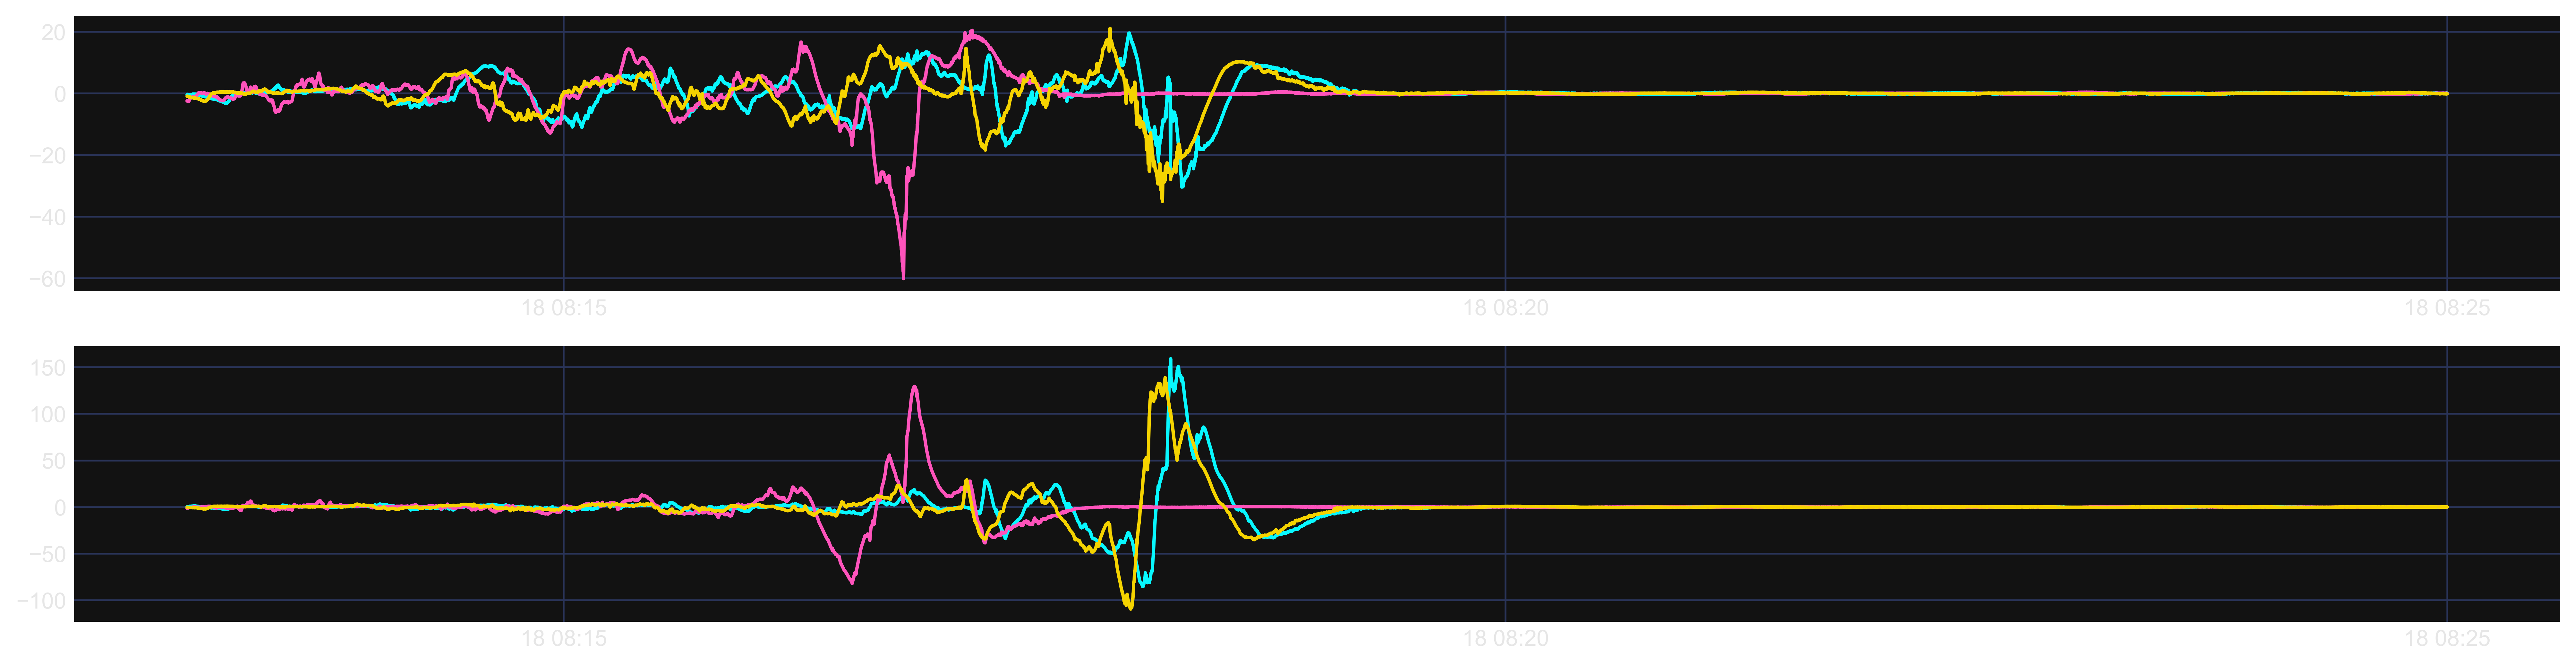

In [7]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, dpi=500)
for i in range(3):
    for j in range(2):
        axes[j].plot(time_xarray[i], data_frame_B[i][:, j])
        


In [8]:
timerange = np.array([datetime(2021, 3, 18, 8, 15), (datetime(2021, 3, 18, 8, 19))])
indicies_in_range=[]
for i in range(3):
    print(time_xarray)
    index_start = np.argmin(np.abs(timerange[0]-time_xarray[i]))
    index_end = np.argmin(np.abs(timerange[1]-time_xarray[i]))
    print(index_start, index_end)
    # creates a list of integers between the index which denotes the start and end
    indicies_in_range.append(np.linspace(
        index_start, index_end, np.abs(index_end-index_start+1), dtype='int'))


[DatetimeIndex(['2021-03-18 08:13:00.014726656',
               '2021-03-18 08:13:00.034726656',
               '2021-03-18 08:13:00.054726656',
               '2021-03-18 08:13:00.074726656',
               '2021-03-18 08:13:00.094726656',
               '2021-03-18 08:13:00.114726656',
               '2021-03-18 08:13:00.134726400',
               '2021-03-18 08:13:00.154726400',
               '2021-03-18 08:13:00.174726400',
               '2021-03-18 08:13:00.194726400',
               ...
               '2021-03-18 08:24:59.817406208',
               '2021-03-18 08:24:59.837406208',
               '2021-03-18 08:24:59.857406208',
               '2021-03-18 08:24:59.877406464',
               '2021-03-18 08:24:59.897406464',
               '2021-03-18 08:24:59.917406208',
               '2021-03-18 08:24:59.937406208',
               '2021-03-18 08:24:59.957406208',
               '2021-03-18 08:24:59.977406208',
               '2021-03-18 08:24:59.997406208'],
              dtype

[30002 30000 29999 ... 18003 18002 18001]
[30002 30000 29999 ... 18003 18002 18001]


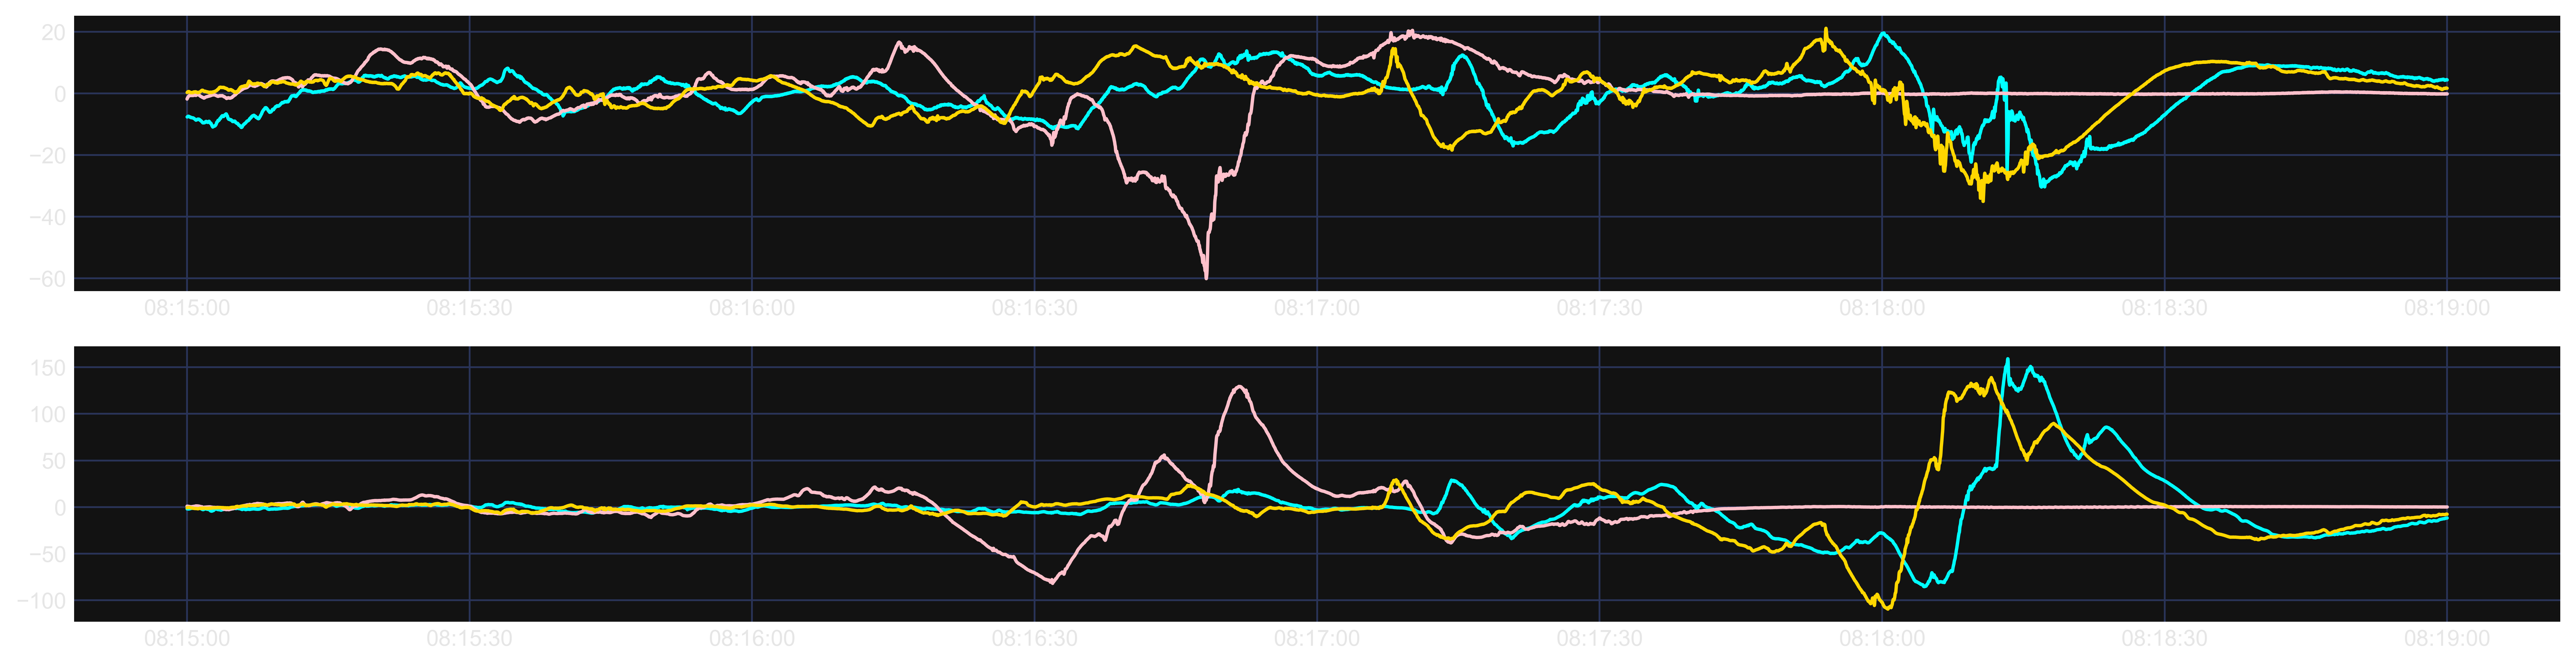

In [9]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, dpi=500)
for i in range(3):
    for j in range(2):
        if(i==0):
            axes[j].plot(time_xarray[i][indicies_in_range[i]], data_frame_B[i]
                         [indicies_in_range[i], j], color='cyan', label='swarm a')  # A
        if(i==1):
            print(indicies_in_range[i])
            axes[j].plot(time_xarray[i][indicies_in_range[i]],
                         data_frame_B[i][indicies_in_range[i], j], color='pink', label='swarm B')  # B
        if(i==2):
            axes[j].plot(time_xarray[i][indicies_in_range[i]], data_frame_B[i]
                         [indicies_in_range[i], j], color='gold', label='swarm C')  # C
##axes[0].set_xlim(datetime(2021, 3, 18, 8, 17), (datetime(2021, 3, 18, 8, 19)))
##axes[1].set_xlim(datetime(2021, 3, 18, 8, 17), (datetime(2021, 3, 18, 8, 19)))


In [10]:
correlation_A_C_E = signal.correlate(
    data_frame_B[0][indicies_in_range[0], 1], data_frame_B[2][indicies_in_range[2], 1], mode = "full")
lags_A_C_E=signal.correlation_lags(len(data_frame_B[0][indicies_in_range[0], 1]),
                        (len(data_frame_B[2][indicies_in_range[2], 1])))  # A and C in east component
print(lags_A_C_E[np.argmax(correlation_A_C_E)])

correlation_A_B_E = signal.correlate(
    data_frame_B[0][indicies_in_range[0], 1], data_frame_B[1][indicies_in_range[1], 1], mode="full")
lags_A_B_E = signal.correlation_lags(len(data_frame_B[0][indicies_in_range[0], 1]),
                               (len(data_frame_B[1][indicies_in_range[1], 1])))  # A and B in east component
print(lags_A_B_E[np.argmax(correlation_A_B_E)])


288
4280


In [11]:
correlation = signal.correlate(
    data_frame_B[0][indicies_in_range[0], 0], data_frame_B[2][indicies_in_range[2], 0], mode="full")
lags = signal.correlation_lags(len(data_frame_B[0][indicies_in_range[0], 0]),
                               (len(data_frame_B[2][indicies_in_range[2], 0])))  # A and C in east component
print(lags[np.argmax(correlation)])

correlation = signal.correlate(
    data_frame_B[0][indicies_in_range[0], 0], data_frame_B[1][indicies_in_range[1], 0], mode="full")
lags = signal.correlation_lags(len(data_frame_B[0][indicies_in_range[0], 0]),
                               (len(data_frame_B[1][indicies_in_range[1], 0])))  # A and B in east component
print(lags[np.argmax(correlation)])


371
4875


0:01:25.600000
0:01:25.600000
0:00:05.760000
0:00:05.760000


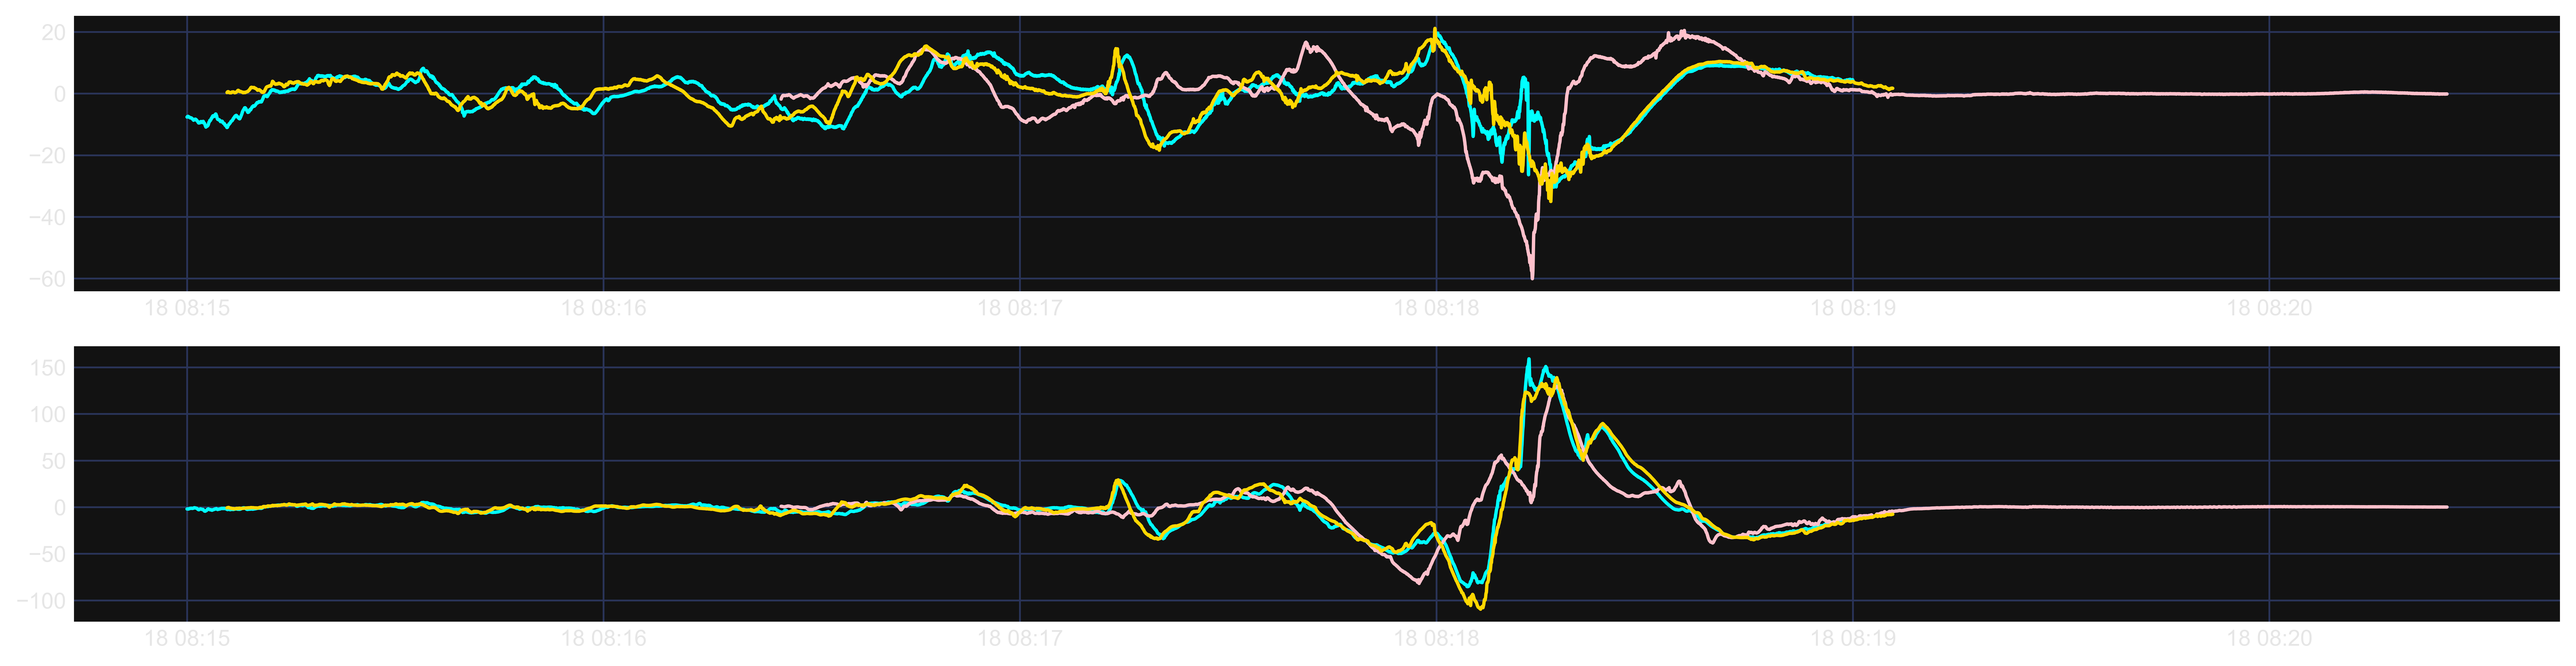

In [12]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, dpi=800)
for i in range(3):
    for j in range(2):
        if(i == 0):
            axes[j].plot(time_xarray[i][indicies_in_range[i]], data_frame_B[i]
                         [indicies_in_range[i], j], color='cyan', label='swarm a')  # A
        if(i == 1):
            print(
                timedelta(seconds=lags_A_B_E[np.argmax(correlation_A_B_E)]/50))
            axes[j].plot(time_xarray[i][indicies_in_range[i]] + timedelta(seconds=lags_A_B_E[np.argmax(correlation_A_B_E)]/50),
                         data_frame_B[i][indicies_in_range[i], j], color='pink', label='swarm B')  # B
        if(i == 2):
            print(
                timedelta(seconds=lags_A_C_E[np.argmax(correlation_A_C_E)]/50))
            axes[j].plot(time_xarray[i][indicies_in_range[i]]+timedelta(seconds=lags_A_C_E[np.argmax(correlation_A_C_E)]/50), data_frame_B[i]
                         [indicies_in_range[i], j], color='gold', label='swarm C')  # C
##axes[0].set_xlim(datetime(2021, 3, 18, 8, 17), (datetime(2021, 3, 18, 8, 19)))
##axes[1].set_xlim(datetime(2021, 3, 18, 8, 17), (datetime(2021, 3, 18, 8, 19)))
            


Electric fields now

In [13]:
#request high resolution magnetic data for swarm A during the auroral interval in Miles Et Al
Electric_products = ['SW_EXPT_EFIA_TCT16',
                     'SW_EXPT_EFIB_TCT16']
data_frame = []
time_range = (datetime(2021, 3, 18, 8, 13), datetime(2021, 3, 18, 8, 25))
time_xarray = []
E_data_used=[]
V_data_used=[]
for i in range(2):
    request = SwarmRequest()
    request.set_collection(
        Electric_products[i])
    request.set_products(
        measurements=["Ehx", "Ehy", "Ehz", "VsatN", "VsatE", "VsatC"],

    )
    data = request.get_between(
        start_time=time_range[0],
        end_time=time_range[1],
        asynchronous=False,
    )
    # changes data into a dataframe format, which is easy to use
    df_E = data.as_dataframe()
    length_of_timeseries = len(df_E)
      

    # E derived from the horizontal sensor
    E_data_numpy = df_E[['Ehx', 'Ehy', 'Ehz']].to_numpy()
    V_data_numpy = df_E[['VsatN', 'VsatE', 'VsatC']].to_numpy()
    E_data_used_intermediate=np.zeros((length_of_timeseries,3))
    V_data_used_intermediate = np.zeros((length_of_timeseries, 3))

    for j in range(length_of_timeseries):
        for k in range(3):

            E_data_used_intermediate[j][k] = E_data_numpy[j][k] #hacky hack

            V_data_used_intermediate[j][k] = V_data_numpy[j][k]
    E_data_used.append(E_data_used_intermediate)
    V_data_used.append(V_data_used_intermediate)

    time_xarray.append(df_E['Ehx'].index)
    ##time_xarray.append(df_b['B_NEC'].index)
    data_frame.append(E_data_used)
time_xarray[1] = np.flip(time_xarray[1])


Downloading: 100%|██████████|  [ Elapsed: 00:04, Remaining: 00:00 ] (0.53MB)
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.53MB)


In [14]:
ElectricNEC=np.zeros((2, len(V_data_used[0]), 3))
for i in range(2):
#Transforms E into NEC
    VelocitySum = V_data_used[i].sum(axis=1)
    # Normalizes and finds unitary
    Velocity_Unit = V_data_used[i] / \
        VelocitySum[:, np.newaxis]  # normalizes
    if(i==0):
        print(Velocity_Unit)

    ElectricNEC[i] = np.multiply(
        Velocity_Unit, E_data_used[i])
    if(i==0):
        print(ElectricNEC[i])


[[ 1.29161968e+00 -2.90727742e-01 -8.91941766e-04]
 [ 1.29147304e+00 -2.90580897e-01 -8.92147168e-04]
 [ 1.29132403e+00 -2.90431675e-01 -8.92355847e-04]
 ...
 [ 1.00089020e+00  2.67554123e-04 -1.15775286e-03]
 [ 1.00088505e+00  2.72485173e-04 -1.15753854e-03]
 [ 1.00087999e+00  2.77337846e-04 -1.15732761e-03]]
[[-1.27090908e+01  1.28172712e+01  3.86878601e-04]
 [ 4.70839315e+00 -6.04891873e+00 -1.46349350e-04]
 [-2.26461228e+01  7.73945174e+00  6.56694334e-04]
 ...
 [ 1.75453367e+01  1.37071018e-02 -1.13813013e-02]
 [ 2.09341485e+00  5.80173087e-03 -1.44661076e-03]
 [ 2.27539744e+01  1.82366709e-02 -1.47549756e-02]]


[-12.70909075   4.70839315 -22.64612279 ...  17.5453367    2.09341485
  22.75397439]
[ 1.28172712e+01 -6.04891873e+00  7.73945174e+00 ...  1.37071018e-02
  5.80173087e-03  1.82366709e-02]
[ 0.00038688 -0.00014635  0.00065669 ... -0.0113813  -0.00144661
 -0.01475498]
[ 6.69639752 14.24101857 -8.20922969 ... 15.57986692 16.57348196
 15.78555998]
[-0.19388541 -0.19467063 -0.0281649  ... -0.29089027 -0.72992954
 -0.15904716]
[ 0.00535845  0.01046449 -0.00543123 ...  0.00115386  0.00128504
  0.00114905]


IndexError: index 2 is out of bounds for axis 0 with size 2

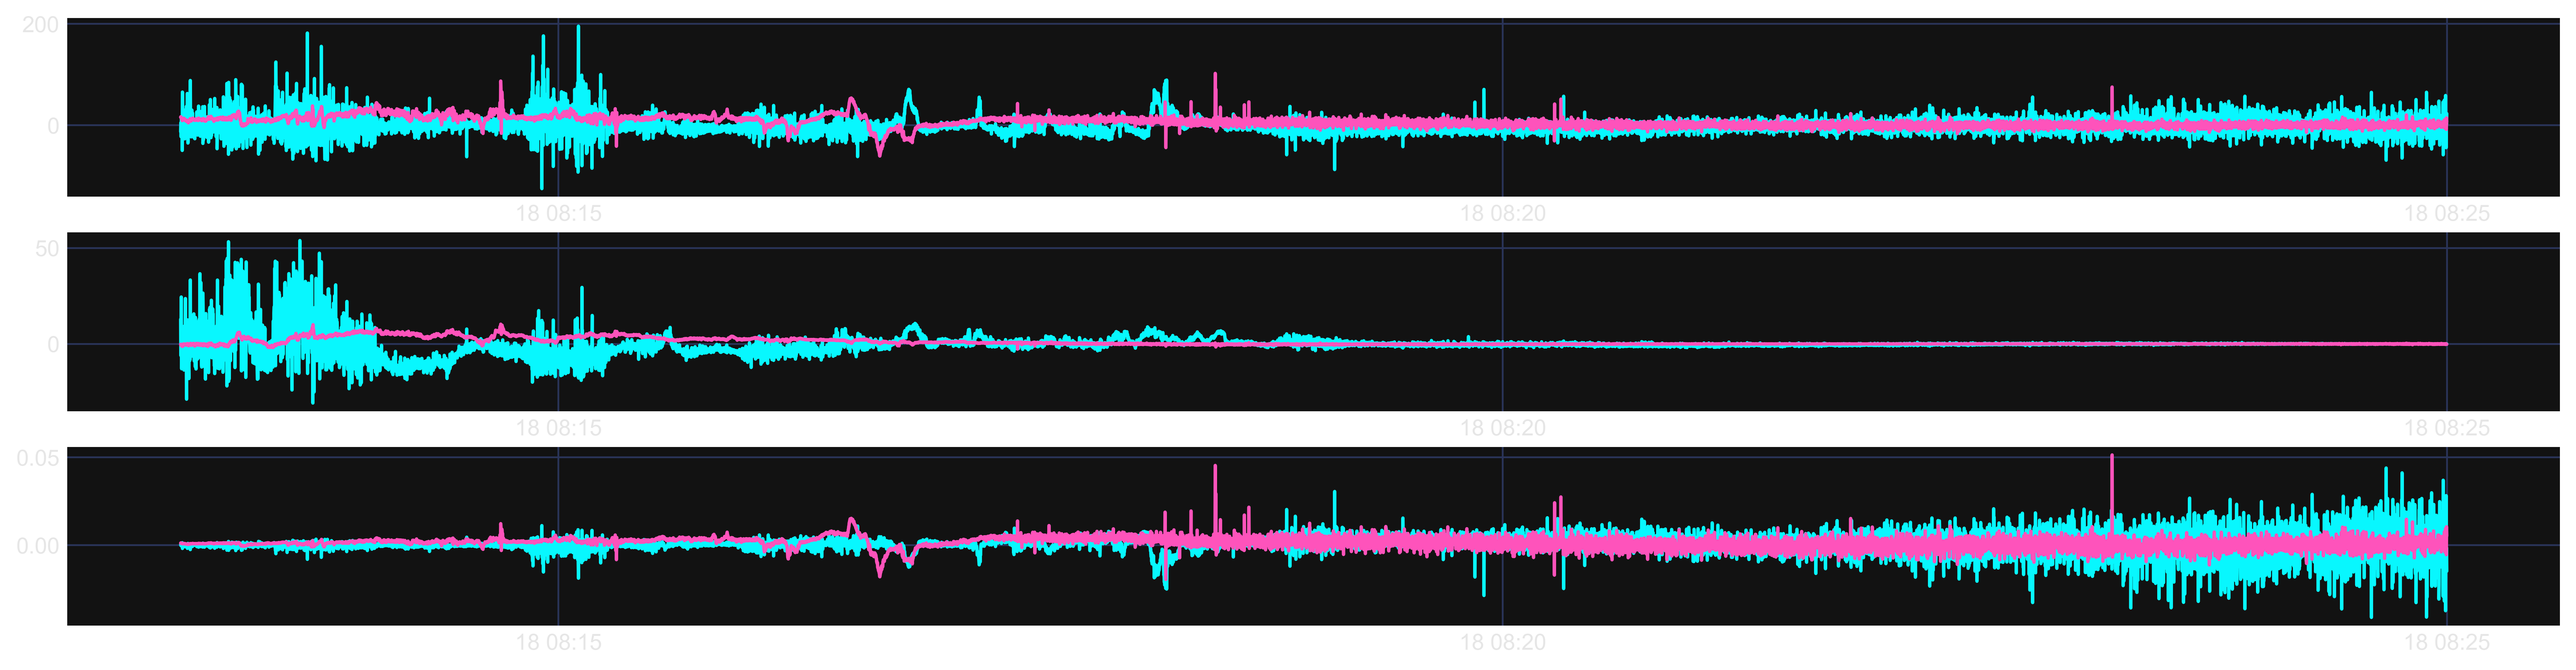

In [15]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(3):
    for j in range(3):
        print(ElectricNEC[i][:, j])
        axes[j].plot(time_xarray[i], ElectricNEC[i][:, j])


In [ ]:
timerange = np.array([datetime(2021, 3, 18, 8, 15),
                      (datetime(2021, 3, 18, 8, 19))])
indicies_in_range = []
for i in range(2):
    print(time_xarray)
    index_start = np.argmin(np.abs(timerange[0]-time_xarray[i]))
    index_end = np.argmin(np.abs(timerange[1]-time_xarray[i]))
    print(index_start, index_end)
    # creates a list of integers between the index which denotes the start and end
    indicies_in_range.append(np.linspace(
        index_start, index_end, np.abs(index_end-index_start+1), dtype='int'))


[DatetimeIndex(['2021-03-18 08:13:00.006750208',
               '2021-03-18 08:13:00.068749824',
               '2021-03-18 08:13:00.131750144',
               '2021-03-18 08:13:00.193750016',
               '2021-03-18 08:13:00.256750080',
               '2021-03-18 08:13:00.318749952',
               '2021-03-18 08:13:00.381750016',
               '2021-03-18 08:13:00.443749888',
               '2021-03-18 08:13:00.506750208',
               '2021-03-18 08:13:00.568749824',
               ...
               '2021-03-18 08:24:59.381750016',
               '2021-03-18 08:24:59.443749888',
               '2021-03-18 08:24:59.506750208',
               '2021-03-18 08:24:59.568749824',
               '2021-03-18 08:24:59.631750144',
               '2021-03-18 08:24:59.693750016',
               '2021-03-18 08:24:59.756750080',
               '2021-03-18 08:24:59.818749952',
               '2021-03-18 08:24:59.881750016',
               '2021-03-18 08:24:59.943749888'],
              dtype

[9599 9597 9596 ... 5761 5760 5759]
[9599 9597 9596 ... 5761 5760 5759]


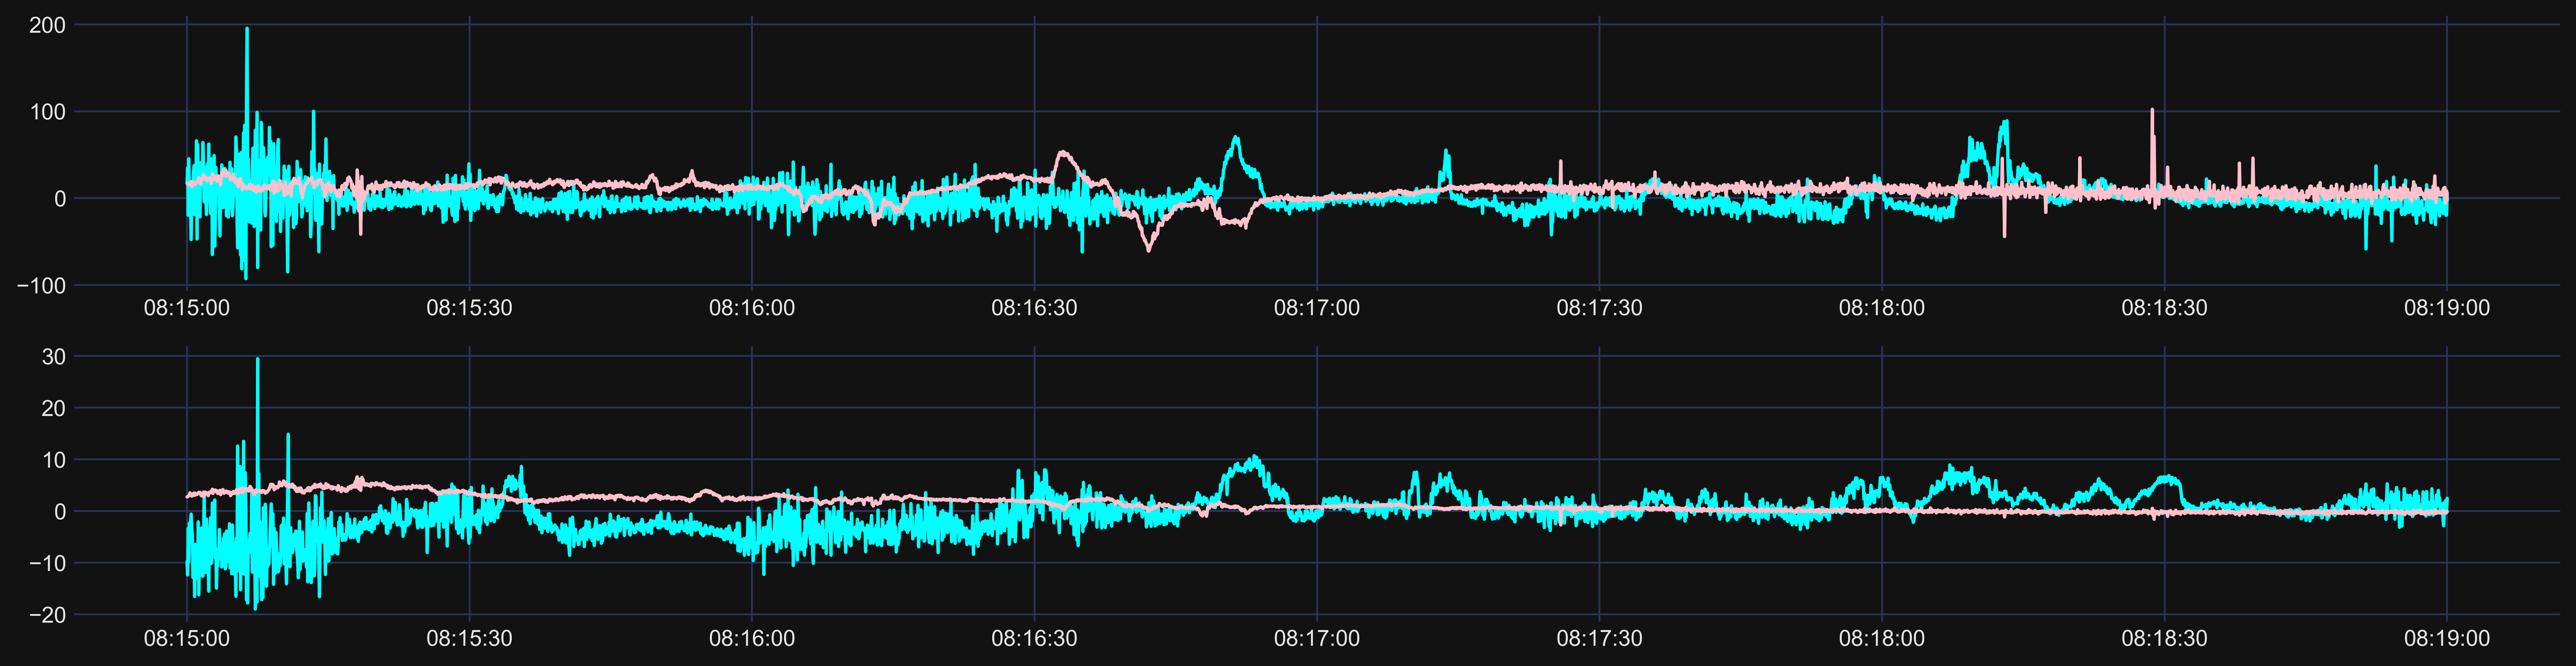

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, dpi=500)
for i in range(2):
    for j in range(2):
        if(i == 0):
            axes[j].plot(time_xarray[i][indicies_in_range[i]], ElectricNEC[i]
                         [indicies_in_range[i], j], color='cyan', label='swarm a')  # A
        if(i == 1):
            print(indicies_in_range[i])
            axes[j].plot(time_xarray[i][indicies_in_range[i]],
                         ElectricNEC[i][indicies_in_range[i], j], color='pink', label='swarm B')  # B


In [ ]:
correlation_A_B_E = signal.correlate(
    ElectricNEC[0][indicies_in_range[0], 0], ElectricNEC[1][indicies_in_range[1], 0], mode="full")
lags_A_B_E = signal.correlation_lags(len(ElectricNEC[0][indicies_in_range[0]]),
                                     (len(ElectricNEC[1][indicies_in_range[1], 0])))  # A and B in east component
print(lags_A_B_E[np.argmax(correlation_A_B_E)])


1732


0:00:34.640000
0:00:34.640000


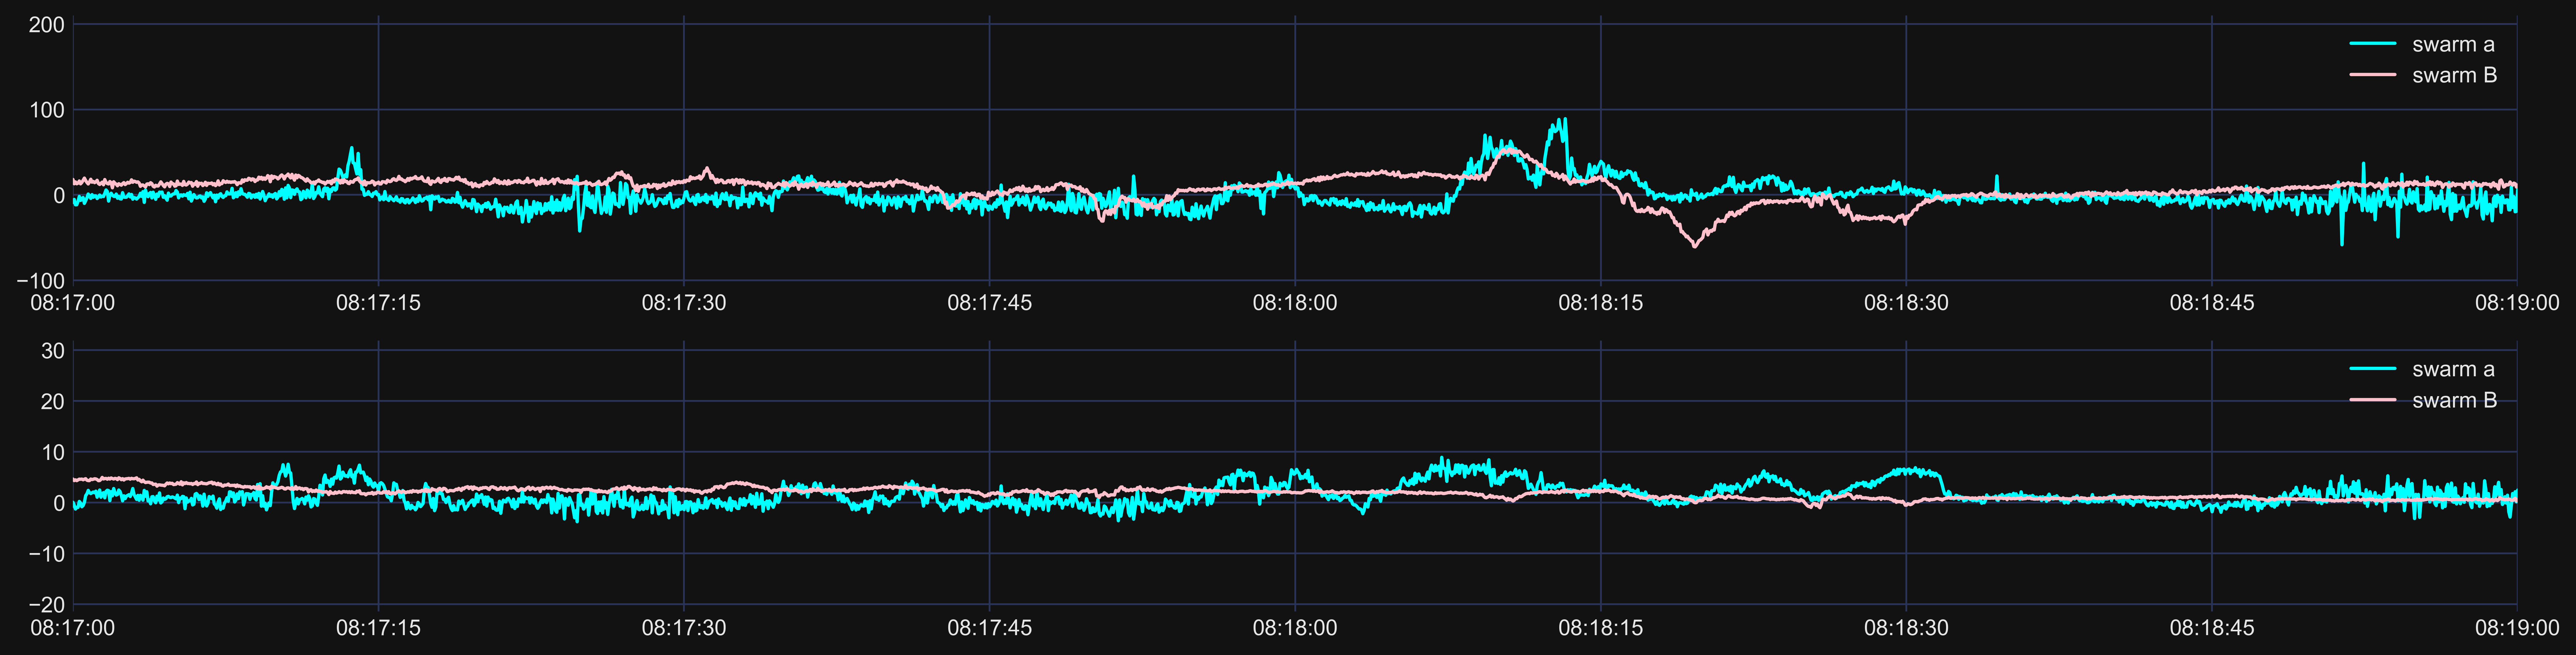

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, dpi=500)
for i in range(3):
    for j in range(2):
        if(i == 0):
            axes[j].plot(time_xarray[i][indicies_in_range[i]], ElectricNEC[i]
                         [indicies_in_range[i], j], color='cyan', label='swarm a')  # A
        if(i == 1):
            print(
                timedelta(seconds=lags_A_B_E[np.argmax(correlation_A_B_E)]/50))
            axes[j].plot(time_xarray[i][indicies_in_range[i]]+timedelta(seconds=97.5) ,
                         ElectricNEC[i][indicies_in_range[i], j], color='pink', label='swarm B')  # B
        axes[j].set_xlim(datetime(2021,3,18,8,17),datetime(2021,3,18,8,19))
        axes[j].legend()

In [ ]:
#Change B to 16Hz

B_16Hz = np.zeros((2,len(ElectricNEC[0]), 3))
print(np.shape(B_16Hz))
for i in range(2):
    for j in range(3):
    # NEED TO CHECK, pretty sure its just decimating and using aliasing filters
        print(np.shape(data_frame_B[i][:,j]))
        print(np.shape(resampy.resample(data_frame_B[i][:, j], 50, 16)))
        B_16Hz[i,:, j] = resampy.resample(data_frame_B[i][:, j], 50, 16)
print(B_16Hz)


(2, 11520, 3)
(36002,)
(11520,)
(36002,)
(11520,)
(36002,)
(11520,)
(36003,)
(11520,)
(36003,)
(11520,)
(36003,)
(11520,)
[[[-0.25235815  0.18405313  0.12514461]
  [-0.39749616  0.35968161  0.21453831]
  [-0.30574988  0.34926131  0.22025204]
  ...
  [-0.0134274   0.11131518 -0.05402749]
  [ 0.02749451  0.08020725 -0.05917278]
  [ 0.05284596  0.07971167 -0.0914754 ]]

 [[ 0.00402714  0.05775531  0.01846208]
  [ 0.02830574  0.11893852  0.04496444]
  [ 0.05646655  0.09742544  0.01630125]
  ...
  [-2.51585424 -1.08058138  0.23683088]
  [-2.45552052 -1.10792542  0.20029316]
  [-2.359228   -1.15000894  0.22046207]]]


In [ ]:
poyntingflux=np.cross(ElectricNEC*1e-3, B_16Hz*1e-9)/(1.256*10**(-6))

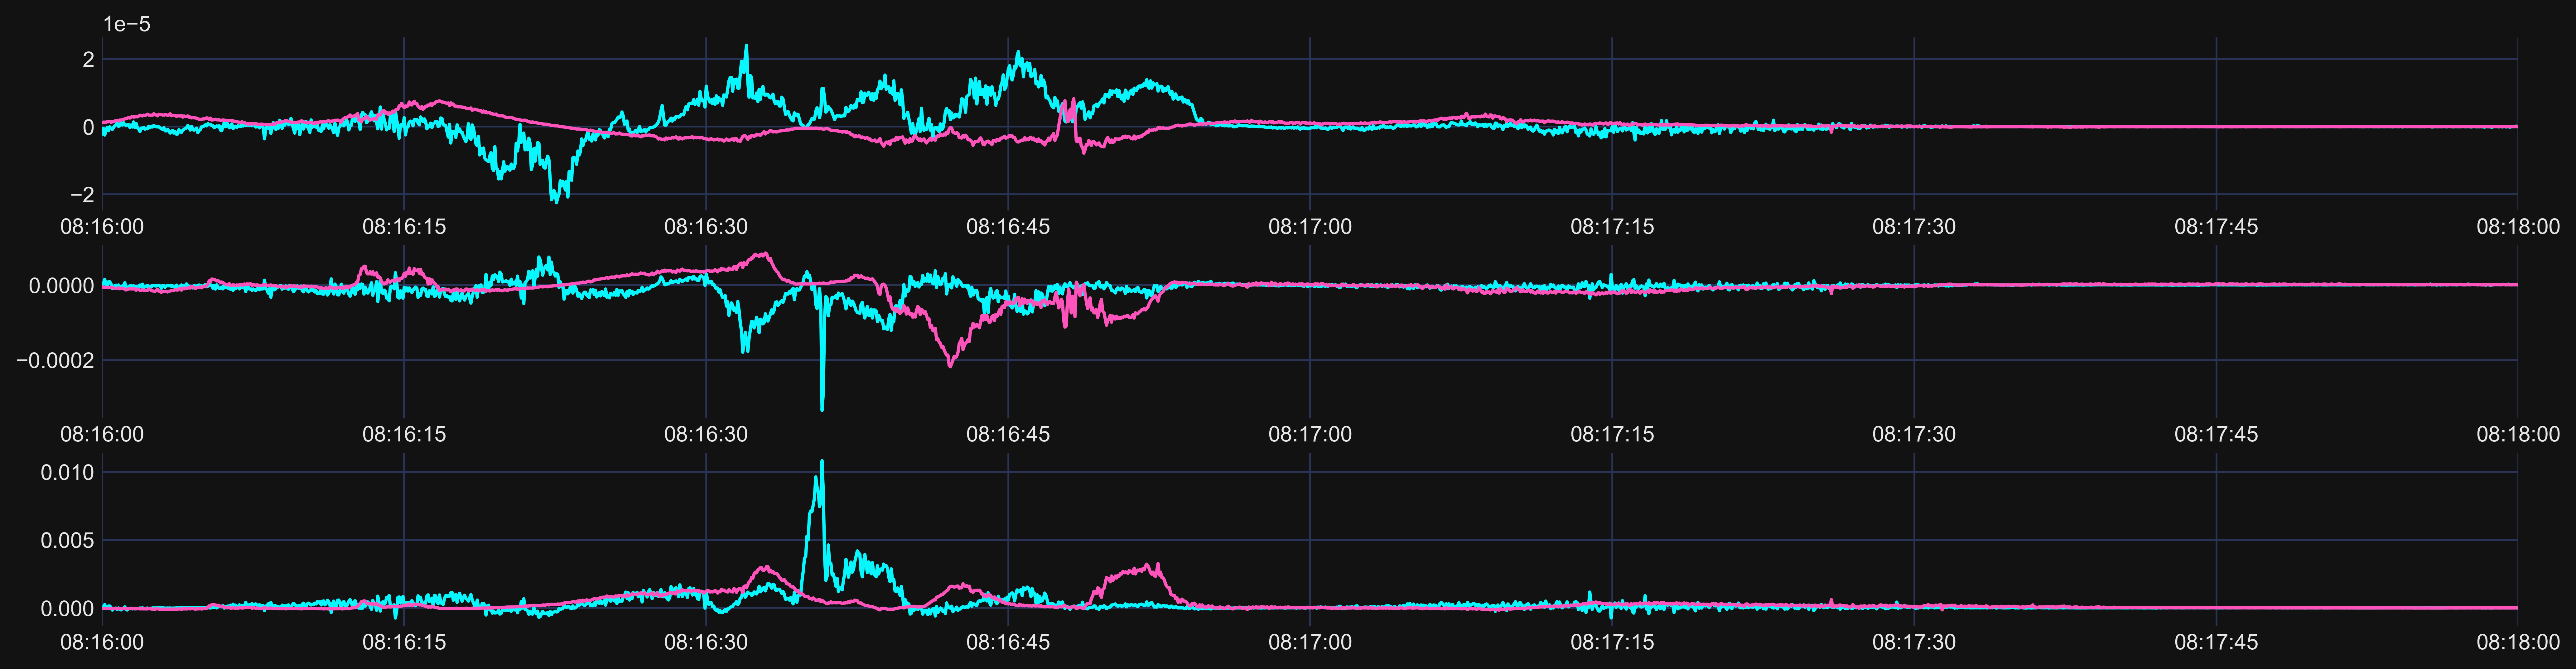

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=3, dpi=500)
for i in range(2):
    for j in range(3):
        if(i==1):
            axes[j].plot(time_xarray[i], -1*poyntingflux[i][:, j])
        else:
            axes[j].plot(time_xarray[i]-timedelta(seconds=97.5), poyntingflux[i][:, j])
        axes[j].set_xlim(datetime(2021,3,18,8,16),datetime(2021,3,18,8,18))


Field align current alignent

In [ ]:
#request high resolution magnetic data for swarm A during the auroral interval in Miles Et Al
FAC_PRODUCTS = ["SW_OPER_FACATMS_2F",
                     "SW_OPER_FACBTMS_2F"]
data_frame = []
time_range = (datetime(2021, 3, 18, 8, 13), datetime(2021, 3, 18, 8, 25))
time_xarray = []
E_data_used=[]
V_data_used=[]
for i in range(2):
    request = SwarmRequest()
    request.set_collection(
        FAC_PRODUCTS[i])
    request.set_products(
        measurements=["FAC", "FAC_Error", 
                  "Flags", "Flags_F", "Flags_B", "Flags_q"]

    )
    data = request.get_between(
        start_time=time_range[0],
        end_time=time_range[1],
        asynchronous=False,
    )
    # changes data into a dataframe format, which is easy to use
    df_E = data.as_dataframe()
    length_of_timeseries = len(df_E)

    time_xarray.append(df_E['FAC'].index)
    ##time_xarray.append(df_b['B_NEC'].index)
    data_frame.append(df_E['FAC'].to_numpy())
time_xarray[1] = np.flip(time_xarray[1])


Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.096MB)
Downloading: 100%|██████████|  [ Elapsed: 00:17, Remaining: 00:00 ] (0.096MB)


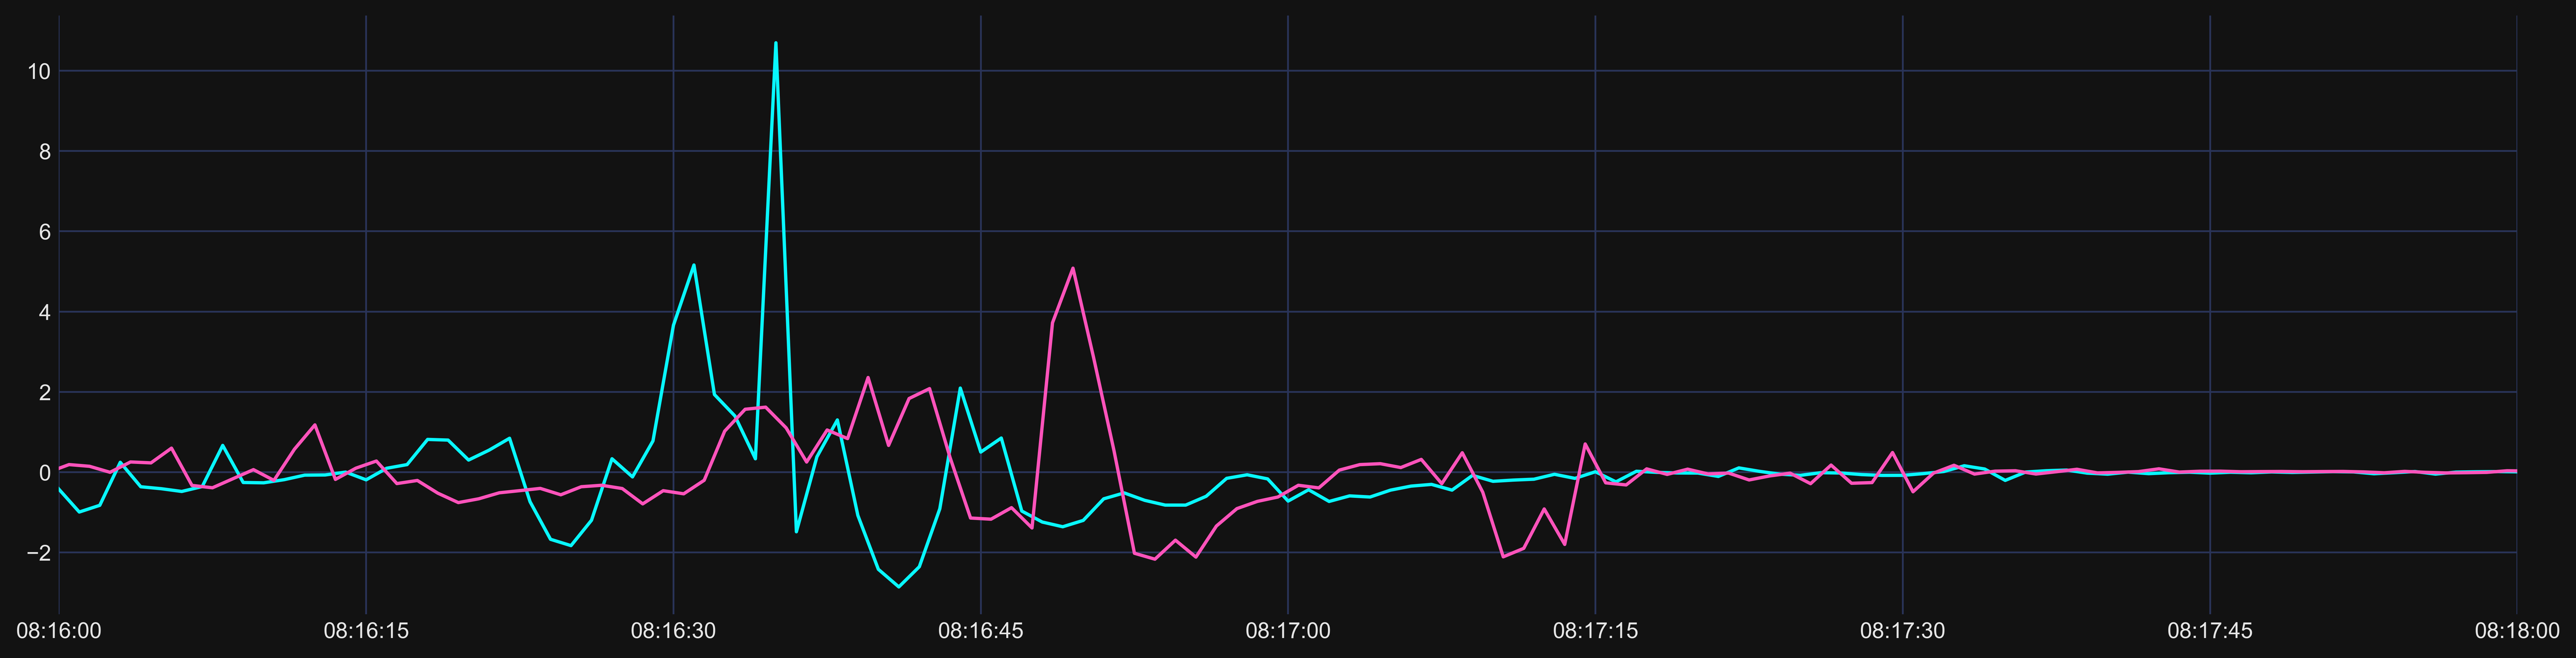

In [ ]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=1, dpi=500)
for i in range(2):
    if(i == 1):
        axes.plot(time_xarray[i], data_frame[i])
    else:
        axes.plot(time_xarray[i]-timedelta(seconds=97.5),
                        data_frame[i])
    axes.set_xlim(datetime(2021,3,18,8,16),datetime(2021,3,18,8,18))

We need to check out some angle of attack corrections

To do this, we need to take these steps,

Convert to magnetic coordinates, as in magnetic coordinates, the aurora is a straight line

Then we can find the angle from constant magnetic latitude to the satellite using simple trig

In [ ]:
#Lets get the coordinates of the satellites
import aacgmv2
data_product = ["SW_OPER_MAGA_HR_1B", "SW_OPER_MAGB_HR_1B"]
emph_data=[]
time_range=(datetime(2021,3,18,8,20), datetime(2021,3,18,8,22))
satellites_selected_dict = {
    "time_range": time_range,
    "satellite_graph": ["swarma", "swarmb", "swarmc", "epop"]
}

def requester(sc_collection, measurement, residual, sampling_step=None, dict=None, cadence=0, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if(residual == True):
            request.set_products(measurements=measurement, models=[
                "CHAOS"], residuals=True, sampling_step=sampling_step)
        else:
            request.set_products(measurements=measurement, models=[
                "CHAOS"], sampling_step=sampling_step)
        data = request.get_between(
            dict['time_range'][0], dict['time_range'][1]+timedelta(seconds=cadence), **kwargs)
        df = data.as_dataframe()
    except:
        df = []
    return df





def empharisis_processing(cadence,i):
    space_craft = []
    data_stuff = []
    data_stuff = requester(
        data_product[i], "B_NEC", True,
        asynchronous=False, show_progress=False, dict=satellites_selected_dict, sampling_step="PT{}S".format(cadence), cadence=cadence)
    time_array = data_stuff['Latitude'].index.to_numpy()
    # Since time array is one hertz and we want to look for 1/cadence hertz we simply use
    lat_satellite_not_footprint = data_stuff['Latitude'].to_numpy()
    lon_satellite_not_footprint = data_stuff['Longitude'].to_numpy()
    altitude = data_stuff['Radius'].to_numpy()/1000-6378.1370
    # delete_array = np.linspace(0, cadence-1, cadence, dtype=int)
    delete_array = 0
    lat, lon, ignore = lat, lon, ignored = aacgmv2.convert_latlon_arr(
        in_lat=lat_satellite_not_footprint, in_lon=lon_satellite_not_footprint, height=altitude, dtime=datetime(2021, 3, 18, 8, 0), method_code='G2A')
    emph = [np.delete(time_array, delete_array), np.delete(lat, delete_array), np.delete(
        lon, delete_array), np.delete(altitude, delete_array)]
    # emph.append([time_array, lat_satellite_not_footprint,
    # lon_satellite_not_footprint, altitude])
    space_craft.append(data_stuff['Spacecraft'].to_numpy()[0])
    # print(emph)
    return emph
angle = []
for i in range(2):
    emph_data.append(empharisis_processing(3,i))
    angle.append(np.rad2deg(np.arctan(np.diff(emph_data[i][2])/np.diff(emph_data[i][1]))))
data_angle=[]
for i in range(len(angle[0])):
    data_angle.append([angle[0][i], emph_data[0][0][i]])
print(data_angle)



[[-9.36370956671204, numpy.datetime64('2021-03-18T08:20:03.032788992')], [-9.201518183304174, numpy.datetime64('2021-03-18T08:20:06.032632832')], [-9.04188462628402, numpy.datetime64('2021-03-18T08:20:09.032476672')], [-8.884883541126385, numpy.datetime64('2021-03-18T08:20:12.032320256')], [-8.730287628617207, numpy.datetime64('2021-03-18T08:20:15.032164096')], [-8.578186686595583, numpy.datetime64('2021-03-18T08:20:18.032015616')], [-8.428427248880833, numpy.datetime64('2021-03-18T08:20:21.031859456')], [-8.281002930883147, numpy.datetime64('2021-03-18T08:20:24.031703296')], [-8.13592439877196, numpy.datetime64('2021-03-18T08:20:27.031546880')], [-7.9930228558315894, numpy.datetime64('2021-03-18T08:20:30.031390720')], [-7.852375926923212, numpy.datetime64('2021-03-18T08:20:33.031234304')], [-7.713768646005071, numpy.datetime64('2021-03-18T08:20:36.031078144')], [-7.577361758014739, numpy.datetime64('2021-03-18T08:20:39.030921984')], [-7.442945294592743, numpy.datetime64('2021-03-18T08